# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
from matplotlib import pyplot as plt
from math import factorial
from functools import reduce
from scipy import stats as st

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv('/datasets/megaline_users.csv')
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')


## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
df_plans.sample(2)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Este dataframe contiene solo dos filas que corresponden a los dos paquetes que ofrece Megaline. La columna de 'mb_per_month_included' sobre los megabytes que ofrece cada plan por mes, será transformada a GB.

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
df_plans.drop(['mb_per_month_included'], axis=1, inplace= True)

## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [6]:
df_plans.insert(1,'gb_per_month_included',['15','30'],True)
df_plans.rename(columns = {'gb_per_month_included':'GB_per_month'}, inplace=True)
df_plans['plan_name'].astype(str)
df_plans.head()

,messages_included,GB_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
492,1492,Elvie,Jones,63,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-03-07,surf,NaN
444,1444,Glinda,Dickerson,70,"New Haven-Milford, CT MSA",2018-06-20,surf,NaN
219,1219,Gavin,Keller,51,"Detroit-Warren-Dearborn, MI MSA",2018-05-14,surf,NaN
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27
459,1459,Santos,Head,40,"San Francisco-Oakland-Berkeley, CA MSA",2018-04-27,ultimate,NaN
125,1125,Assunta,Carver,39,"North Port-Sarasota-Bradenton, FL MSA",2018-08-16,surf,NaN
290,1290,Thaddeus,Compton,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-14,surf,NaN
483,1483,Miguel,Farrell,35,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-25,surf,NaN
247,1247,Marion,Singleton,75,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-04-12,ultimate,NaN
236,1236,Odell,Juarez,74,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-04-04,ultimate,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

La columna 'churn_date' contiene una muy gran cantidad de NaN, debido a los usuarios que aún mantenían un plan con la compañía cuando la información fue tomada, se reemplazará por un espacio en blanco ' '. Las columnas 'reg_date' y 'churn_date' son poco intuitivas, así que se las cambiará a 'subscription_date' y 'cancel_date'.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [9]:
df_users.fillna('', inplace=True)
df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
92,1092,Taren,Strickland,26,"Dallas-Fort Worth-Arlington, TX MSA",2018-12-10,surf,
314,1314,Brice,Morgan,35,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-03-06,ultimate,
243,1243,Isaias,Compton,71,"Phoenix-Mesa-Chandler, AZ MSA",2018-05-11,surf,
121,1121,Kathaleen,Albert,34,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-13,surf,
285,1285,Joesph,Barry,28,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-08-03,surf,
370,1370,Nenita,Vasquez,49,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-09-12,ultimate,
119,1119,Anderson,Palmer,60,"Louisville/Jefferson County, KY-IN MSA",2018-10-05,surf,
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
250,1250,Milan,Sellers,57,"Houston-The Woodlands-Sugar Land, TX MSA",2018-04-03,ultimate,
64,1064,Gerardo,Ashley,46,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-03,surf,


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [10]:
df_users.rename(columns ={'reg_date':'subscription_date','churn_date':'cancel_date'}, inplace=True)
df_users.head(15)

,user_id,first_name,last_name,age,city,subscription_date,plan,cancel_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,


## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
df_calls.sample(20)

,id,user_id,call_date,duration
24565,1094_620,1094,2018-11-16,8.05
94288,1336_132,1336,2018-08-29,0.00
510,1003_120,1003,2018-12-18,5.97
121419,1427_87,1427,2018-06-27,6.67
111664,1392_74,1392,2018-09-19,15.90
12670,1055_77,1055,2018-09-30,6.42
51846,1187_39,1187,2018-12-03,9.78
22867,1083_140,1083,2018-11-06,4.33
31469,1118_272,1118,2018-12-14,17.21
28692,1109_319,1109,2018-05-14,0.00


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

El dataframe no posee valores ausentes. En la columna 'user_id' existen valores duplicados, pero es normal que existan duplicados en este tipo de datos sobre usuarios únicos donde aparecen varias veces. Los datos de 'duration' deben ser redondeados al  siguiente número entero. Y se añadirá una columna 'month' para indicar en que mes del año se realizó la llamada.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [13]:
df_calls['duration']= df_calls['duration'].apply(np.ceil)
print(df_calls['duration'])

0          9.0
1         14.0
2         15.0
3          6.0
4          5.0
          ... 
137730     9.0
137731    11.0
137732     9.0
137733     1.0
137734    14.0
Name: duration, Length: 137735, dtype: float64


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [14]:
df_calls.rename(columns= {'duration':'duration_in_minutes'},inplace=True)
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls.sample(10)

,id,user_id,call_date,duration_in_minutes,month
70957,1252_381,1252,2018-08-01,9.0,8
12986,1056_129,1056,2018-09-13,11.0,9
122363,1432_213,1432,2018-10-23,11.0,10
95928,1340_278,1340,2018-10-19,3.0,10
126058,1446_260,1446,2018-12-28,12.0,12
117084,1409_58,1409,2018-10-29,5.0,10
128219,1460_296,1460,2018-10-18,9.0,10
109938,1387_310,1387,2018-12-13,10.0,12
91014,1328_644,1328,2018-08-13,13.0,8
79774,1285_273,1285,2018-11-19,14.0,11


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
df_messages.sample(10)

,id,user_id,message_date
23203,1140_25,1140,2018-09-02
6565,1056_75,1056,2018-08-04
12221,1080_224,1080,2018-09-21
65366,1419_175,1419,2018-12-26
23273,1141_49,1141,2018-09-09
73289,1470_917,1470,2018-06-03
21191,1132_430,1132,2018-04-22
51611,1335_201,1335,2018-12-28
65026,1416_17,1416,2018-12-29
20429,1130_104,1130,2018-10-28


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

El dataframe no presenta errores que corregir netamenete. Lo que si se puede enriquecer es añadiendo una columna que indique la información del mes en que se realizó el mensaje.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

No existe un error que corregir netamente.

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [17]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages.sample(10)

,id,user_id,message_date,month
47238,1320_482,1320,2018-12-17,12
5928,1055_46,1055,2018-09-30,9
71509,1466_161,1466,2018-10-27,10
61655,1385_119,1385,2018-08-01,8
6843,1057_167,1057,2018-12-27,12
45359,1304_565,1304,2018-10-31,10
46035,1313_231,1313,2018-10-01,10
23917,1144_415,1144,2018-06-25,6
33204,1209_13,1209,2018-11-21,11
7157,1059_27,1059,2018-10-15,10


## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.sample(10)

,id,user_id,session_date,mb_used
7023,1039_298,1039,2018-07-07,317.00
17962,1081_19,1081,2018-10-02,315.74
1202,1007_186,1007,2018-10-26,1002.00
20469,1095_125,1095,2018-11-09,254.53
1916,1010_72,1010,2018-08-13,1070.71
23717,1109_295,1109,2018-10-20,575.75
16390,1073_327,1073,2018-11-12,378.80
22367,1101_259,1101,2018-07-08,141.43
99473,1468_297,1468,2018-10-05,464.93
15623,1071_234,1071,2018-09-21,123.23


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Lo más relevante es la columna 'mb_used' para volver más homogeneo al momento de leer esta información con los otros dataframes se lo convertirá a GB dividiendolo para 1024. Y añadir una columna con el mes donde realizó la sesión.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [20]:
df_internet['mb_used'] = df_internet['mb_used']/1024

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [21]:
df_internet.rename(columns= {'mb_used':'gb_used'},inplace=True)
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet.head(20)

,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,12
1,1000_204,1000,2018-12-31,0.000000,12
2,1000_379,1000,2018-12-28,0.644922,12
3,1000_413,1000,2018-12-26,0.264639,12
4,1000_442,1000,2018-12-27,0.859590,12
5,1001_0,1001,2018-08-24,0.278008,8
6,1001_3,1001,2018-12-09,0.640664,12
7,1001_4,1001,2018-11-04,0.016572,11
8,1001_10,1001,2018-11-27,0.132012,11
9,1001_15,1001,2018-12-13,0.744062,12


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [22]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
df_plans

,messages_included,GB_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [23]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
per_month_calls = df_calls.groupby(['user_id', 'month'])['id'].count()
df_total_calls = pd.DataFrame({'per_month_calls':per_month_calls}).reset_index()
display(df_total_calls)

,user_id,month,per_month_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [24]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_month = df_calls.groupby(['user_id','month'])['duration_in_minutes'].sum()
df_total_minutes = pd.DataFrame({'minutes_per_month':minutes_per_month}).reset_index()
display(df_total_minutes)

,user_id,month,minutes_per_month
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [25]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_month = df_messages.groupby(['user_id', 'month'])['id'].count()
df_total_messages = pd.DataFrame({'messages_per_month':messages_per_month}).reset_index()
display(df_total_messages)

,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [26]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

traffic_per_month = df_internet.groupby(['user_id','month'])['gb_used'].sum().apply(np.ceil)
df_total_traffic= pd.DataFrame({'traffic_per_month': traffic_per_month}).reset_index()
display(df_total_traffic)

,user_id,month,traffic_per_month
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
data_frames = [df_total_calls,df_total_minutes,df_total_messages,df_total_traffic]
per_month_df = reduce(lambda left,right: pd.merge(left,right,on=['month','user_id'],
                                            how='outer'), data_frames).fillna(0)
per_month_df.head(15)


,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0
5,1001,12,56.0,412.0,44.0,19.0
6,1002,10,11.0,59.0,15.0,7.0
7,1002,11,55.0,386.0,32.0,19.0
8,1002,12,47.0,384.0,41.0,15.0
9,1003,12,149.0,1104.0,50.0,27.0


In [28]:
# Añade la información de la tarifa
df_user_plan = df_users[['user_id','plan','city']]
df_plan_information = per_month_df.merge(df_user_plan, on='user_id')
df_plan_information 

,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month,plan,city
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,27.0,182.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,49.0,315.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,65.0,393.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,64.0,426.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,0.0,78.0,36.0,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,10,0.0,0.0,76.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,11,0.0,0.0,72.0,17.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,12,0.0,0.0,61.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [29]:
# Calcula el ingreso mensual para cada usuario
def rev_calc(row):
    if row['plan'] == 'surf':
        revenue = 20 
        if row['minutes_per_month'] > 500:
            revenue += (row['minutes_per_month'] - 500) * .03
        if row['messages_per_month'] > 50: 
            revenue += (row['messages_per_month']-50) * .03
        if row['traffic_per_month'] > 15:
            revenue += (row['traffic_per_month']-15) * 10
    else:
        revenue = 70
        
        if row['minutes_per_month'] > 3000:
            revenue += (row['minutes_per_month'] - 3000) * .01
        if row['messages_per_month'] > 1000: 
            revenue += (row['messages_per_month']-1000) * .01
        if row['traffic_per_month'] > 30:
            revenue += (row['traffic_per_month']-30) * 7
    return revenue

df_plan_information['revenue'] = df_plan_information.apply(rev_calc, axis=1)


In [30]:
df_plan_information

,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month,plan,city,revenue
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,27.0,182.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,49.0,315.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,65.0,393.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,64.0,426.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00
...,...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,0.0,78.0,36.0,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA",112.00
2289,1349,10,0.0,0.0,76.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.78
2290,1349,11,0.0,0.0,72.0,17.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",40.66
2291,1349,12,0.0,0.0,61.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.33


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

Text(0, 0.5, 'Minutos')

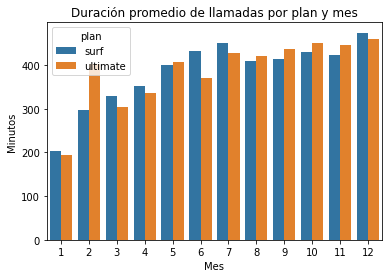

In [31]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
aggregate_data = df_plan_information.groupby(['month','plan'])['minutes_per_month'].mean().reset_index()

sns.barplot(data = aggregate_data, 
            x='month',
            y='minutes_per_month',
            hue = 'plan',
            )

plt.title('Duración promedio de llamadas por plan y mes')
plt.xlabel('Mes')
plt.ylabel('Minutos')


,user_id,plan,minutes_per_month
0,1000,ultimate,124.0
1,1001,surf,1728.0
2,1002,surf,829.0
3,1003,surf,1104.0
4,1004,surf,2772.0
...,...,...,...
485,1495,surf,1765.0
486,1496,surf,1455.0
487,1497,ultimate,300.0
488,1498,surf,3211.0


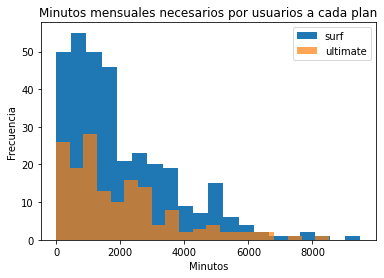

In [32]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

compare_minutes_month = df_plan_information.groupby(['user_id','plan'])['minutes_per_month'].sum().reset_index()
display(compare_minutes_month)
compare_minutes_month[compare_minutes_month['plan'] == 'surf']['minutes_per_month'].plot(kind='hist', bins=20)

compare_minutes_month[compare_minutes_month['plan'] == 'ultimate']['minutes_per_month'].plot(kind='hist', bins=20, alpha=0.7)
plt.legend(['surf', 'ultimate'])
plt.title('Minutos mensuales necesarios por usuarios a cada plan')
plt.ylabel('Frecuencia')
plt.xlabel('Minutos')
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [33]:
# Calcula la media y la varianza de la duración mensual de llamadas.
df_plans_minutes_mean = df_plan_information.groupby(['plan','month'])['minutes_per_month'].mean().reset_index()
display(df_plans_minutes_mean)
df_plans_minutes_variance = df_plan_information.groupby(['plan','month'])['minutes_per_month'].var().reset_index()
display(df_plans_minutes_variance)


,plan,month,minutes_per_month
0,surf,1,203.000000
1,surf,2,297.000000
2,surf,3,330.000000
3,surf,4,351.540000
4,surf,5,399.584416
5,surf,6,431.298969
6,surf,7,449.983471
7,surf,8,410.111111
8,surf,9,414.226804
9,surf,10,429.729958


,plan,month,minutes_per_month
0,surf,1,15842.000000
1,surf,2,52226.500000
2,surf,3,35809.363636
3,surf,4,50866.743265
4,surf,5,59754.219754
5,surf,6,45592.628436
6,surf,7,61005.099725
7,surf,8,54344.645963
8,surf,9,46595.958656
9,surf,10,52278.664056


,user_id,month,minutes_per_month
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2288,1498,12,339.0
2289,1499,9,346.0
2290,1499,10,385.0
2291,1499,11,308.0


Text(0.5, 1.0, 'Duración mensual de llamadas')

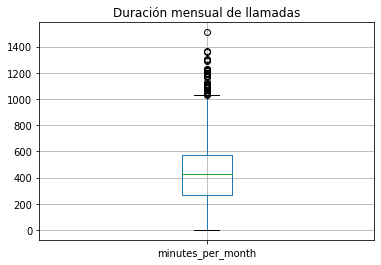

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

merged_monthly_call_plan = df_plan_information.groupby(['user_id','month'])['minutes_per_month'].sum().reset_index()
display(merged_monthly_call_plan)
merged_monthly_call_plan.boxplot(column='minutes_per_month')

plt.title('Duración mensual de llamadas')

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

En el promedio de minutos de llamadas los usuarios del plan 'ultimate' es mayor comparado al de los usuarios del plan 'surf' en la mayoría de los meses. Dando a entender que los usuarios del plan 'ultimate' tienden a realizar más llamadas.

### Mensajes

In [35]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

messages_per_month_plan = df_plan_information.groupby(['plan','month'])['messages_per_month'].sum().reset_index()
messages_per_month_plan

,plan,month,messages_per_month
0,surf,1,21.0
1,surf,2,108.0
2,surf,3,351.0
3,surf,4,870.0
4,surf,5,1849.0
5,surf,6,2454.0
6,surf,7,3271.0
7,surf,8,4662.0
8,surf,9,5968.0
9,surf,10,8020.0


In [36]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

print(df_plan_information.groupby('plan')['traffic_per_month'].sum().reset_index())
print(df_plan_information.groupby('user_id')['traffic_per_month'].sum().reset_index())

       plan  traffic_per_month
0      surf            26223.0
1  ultimate            12461.0
     user_id  traffic_per_month
0       1000                2.0
1       1001               81.0
2       1002               41.0
3       1003               27.0
4       1004              157.0
..       ...                ...
485     1495               99.0
486     1496               66.0
487     1497               11.0
488     1498              228.0
489     1499               72.0

[490 rows x 2 columns]


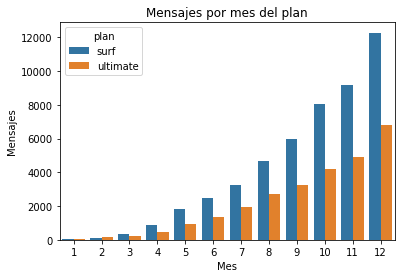

In [37]:
sns.barplot(data=messages_per_month_plan, 
             x='month',
             y='messages_per_month', 
            hue = 'plan' 
           )
plt.title('Mensajes por mes del plan')
plt.xlabel('Mes')
plt.ylabel('Mensajes')
# Show the plot
plt.show()


[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

Se puede evidenciar que el plan 'surf' tiene un mayor uso de mensajes por mes comparado al plan 'ultimate'

### Internet

In [38]:
internet_traffic_per_plan_month = df_plan_information.groupby(['month','plan'])['traffic_per_month'].sum().reset_index()
internet_traffic_per_plan_month

,month,plan,traffic_per_month
0,1,surf,10.0
1,1,ultimate,29.0
2,2,surf,110.0
3,2,ultimate,121.0
4,3,surf,312.0
5,3,ultimate,221.0
6,4,surf,611.0
7,4,ultimate,343.0
8,5,surf,1087.0
9,5,ultimate,489.0


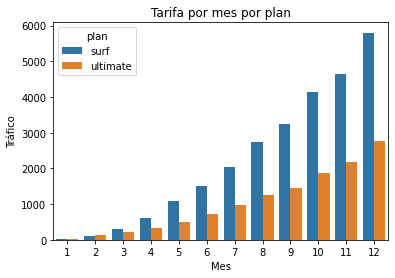

In [39]:
sns.barplot(data=internet_traffic_per_plan_month, 
             x='month',
             y='traffic_per_month', 
            hue = 'plan' 
           )

plt.title('Tarifa por mes por plan')
plt.xlabel('Mes')
plt.ylabel('Tráfico')


plt.show()

In [40]:
m_int = internet_traffic_per_plan_month['traffic_per_month'].mean()
var_int = internet_traffic_per_plan_month['traffic_per_month'].var()
print(m_int)
print(var_int)

1611.8333333333333
2504297.188405797


[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

A través del año va aumentando el consumo del tráfico de Internet, pero los usuarios del plan 'surf' tienen un mayor uso por tener más usuarios comparado a el plan 'ultimate'

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [41]:
revenue_per_plan_month = df_plan_information.groupby(['plan', 'month'])['revenue'].sum().reset_index()
display(revenue_per_plan_month)

ultimate_plan = df_plan_information.query("plan == 'ultimate'")
surf_plan = df_plan_information.query("plan =='surf'")

,plan,month,revenue
0,surf,1,40.00
1,surf,2,309.57
2,surf,3,1056.65
3,surf,4,2035.53
4,surf,5,3667.37
5,surf,6,4779.80
6,surf,7,7583.56
7,surf,8,10356.85
8,surf,9,11304.67
9,surf,10,15504.83


Text(0, 0.5, 'Ingreso')

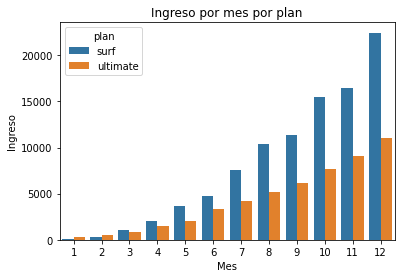

In [42]:
sns.barplot(data=revenue_per_plan_month ,
             x='month', 
             y='revenue',
            hue = 'plan' 
           )

plt.title('Ingreso por mes por plan')
plt.xlabel('Mes')
plt.ylabel('Ingreso')

In [43]:
m_rev = revenue_per_plan_month['revenue'].mean()
var_rev = revenue_per_plan_month['revenue'].var()
print(m_int)
print(var_int)

1611.8333333333333
2504297.188405797


[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

Los ingresos generados por el plan 'surf' son considerablemente mayores a diferencia de los ingresos proporcionados por el plan 'ultimate'

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

h0 = Hipótesis nula. Los ingresos promedio generados por los usuarios son similares para ambos planes.

h1 = Hipótesis alternativa. Los ingresos promedio generado por los usuarios son diferentes para ambos planes.

In [44]:
# Prueba las hipótesis

ultimate_rev = ultimate_plan.groupby('user_id')['revenue'].mean()
surf_rev = surf_plan.groupby('user_id')['revenue'].mean()
alpha = 0.05

results = st.ttest_ind(ultimate_rev, surf_rev)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Se rechaza la hipótesis nula. Ambos grupos generan diferentes ingresos promedio.")
else:
    print("No se rechaza la hipótesis nula. Ambos grupos generan ingresos promedio similares.")


p-value: 0.00011355294752235661
Se rechaza la hipótesis nula. Ambos grupos generan diferentes ingresos promedio.


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

h0 = Hipótesis nula. Los ingresos promedio de los usuarios del área NY-NJ son similares al de otras regiones.

h1= Hipótesis alternativa. Los ingresos promedio de los usuarios del área NY_NJ son diferentes al de otras regiones.

In [45]:
# Prueba las hipótesis

nynj = df_plan_information[df_plan_information['city'].str.contains('NJ', 'NY')==True]
not_nynj = df_plan_information[~df_plan_information['city'].str.contains('NJ', 'NY')==True]

nynj_rev = nynj.groupby('user_id')['revenue'].mean()
not_nynj_rev = not_nynj.groupby('user_id')['revenue'].mean()


alpha = 0.05

results = st.ttest_ind(nynj_rev, not_nynj_rev)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Se rechaza la hipótesis nula. El ingreso promedio de los usuarios de esta área es diferente al de otras regiones.")
else:
    print("No rechazamos la hipótesis nula. No hay una diferencia en el ingreso promedio de los usuarios de esta área comparado a otras regiones.")


p-value: 0.3822374104879729
No rechazamos la hipótesis nula. No hay una diferencia en el ingreso promedio de los usuarios de esta área comparado a otras regiones.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]



Se puede concluir varios puntos:

1. Principalmente que el ingreso generado por el plan 'surf' es superior al plan 'ultimate'.

2. Aparentemente no existe una diferencia notable en el ingreso promedio de los usuarios de las diferentes ciudades y áreas del país.

3. El plan 'surf' supera en uso de mensajes, uso de Internet e ingreso que le genera a la telefónica comparado al plan 'ultimate' que solo en llamadas lo supera.

4. Si se tuviera que sugerir una acción a la telefónica con esta información sería el de promocionar el plan 'surf' ya que este es el que le generaría más ingresos ya sea por la cantidad de usuarios o por los cargos adicionales que se generan.